In [1]:
import numpy as np
#import scipy
import math
from scipy import integrate, LowLevelCallable
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import os, ctypes


In [2]:
# Kinetic correlations and parameters
# Billimoria 1981, Weng 1975 and Price 1977, the hydrogenation of Benzene example!!
prams = {'k0': 3.17e-2,                 # kmol/kgsPa
        'K0': 3.17e13,                 # 1/Pa
        'E' : 5.76e7,                   # J/kmol
        'Q': 6.89e7,                    # J/kmol (-) sign
        'kd0': 1.80e-4,                 # 1/Pa/s
        'Ed': 4.53e6,                   # J/kmol
        'R': 8.3145,                    # J/mol/K
        'MT': 4.05e-4,                  # kg/kmol (from Weng, 1.03e-3, mol/kg_catalyst)
        'DeB': 4.5e-5,                  # m2/s
        'rho_Cp': 1.46e-6,              # J/m3/oC
        'eps': 0.58,
        'rho_B': 4.14e-2,               # kg/m3
        'dH': 2.09e8,                   # J/kmol
        'alpha': 0.32,                  # J/m2K
        'Le':1.48
        }                 


In [3]:
# ccalculation of <rho*Cp>
# <rho*Cp> = rho*Cp (catalyst + diluent) + rho*Cp (reactor wall + thermo_well) + rho_g*eps*Cp_g
# rho*Cp (catalyst + diluent) = [W_T*Cp_c + (1-W_T)*Cp_d]*rho_B

In [4]:
def lambda_e(LeH,rho_g,Cp_g,U,dp):
    return 5.1*LeH+0.8*rho_g*Cp_g*U*dp

In [5]:
def cp_g(xB,xH):
    return (96.86*xB + 2.902*xH)*10**4

In [6]:
def mw_g(xB,xH):
    return 78.12*xB + 2.106*xH

In [7]:
def rho_g_m1(cB,xB,xH):
    return cB*MW_g(xB,xH)/xB

In [8]:
def rho_g_m2(MW_g,P,T0):
    return MW_g*273.16*P/(22.161 + 1.0132e5*T0)

In [9]:
def cp_H(T):
    return 2.9199e4 + 2.0515*(T-400)-1.256e-2*(T-499)**2

In [10]:
def cp_B(T):
    return 1.1196e5 + 2.7528e2*(T-400)-2.1562e-1*(T-400)**2

In [11]:
dT_ad = lambda xB0,dH,MW_g,Cp_g: xB0*(-dH)/(MW_g*Cp_g)
#dT_ad(0.5,120,65,4.14)

In [12]:
# Catalyst effectiveness parameters
pramc = {'Blh': 1,           # no units
         'Blm': 6.5,         # no units, assuming j_d = j_h
         'h': 2.2e2,         # J/m2/s/oC
         'km': 4.1e-2,       # m/s
         'rB': 0.162,        # kmol/m3/s (= k1*cB), assuming kinetics of first order
         'kl': 7.6e-2,       # m3/kg/s
         'rho_c': 4.3e3,     # kg/m3
         'Dc': 5.2e-6,       # m2/s
         'Lc': 0.15,         # J/m/s/oC
         'phi': 2.2,         # no units, r_p/(kl*rho_c/Dc)^(1/3),(2.2 for 12 mesh and 1.1 for 20 mesh)
         'gma': 3.3,         # no units, E/RT = 2700/(1.98*413)
         'bta': 8.56e-3      # no units, cB_0*(-dH)*Dc/(Lc*T_B) 
        }

In [13]:
def rB(P,xB,xH,a,T,prams):
    k0 = prams['k0']                 
    K0 = prams['K0']                 
    E =  prams['E']                 
    Q =  prams['Q']
    R =  prams['R']
    r = -(k0*K0*np.exp((-Q-E)/(R*T))*P**2*xB*xH)/(1 + K0*np.exp(-Q/(R*T))*P*xB)*a
    return r

def rT(P,xT,a,T,prams):
    kd0 = prams['k0']   
    Ed =  prams['Ed']                 
    R =  prams['R']
    MT = prams['MT']
    r = -(kd0*np.exp((-Ed)/(R*T))*P*xT*a)*MT
    return r

In [14]:
def R(c,k):
    r = k*c
    return r

In [15]:
def H(DeltaH,r):
    Q = -DeltaH*r
    return Q

In [16]:
def mass_energy_bal(y, t):
    # Define concentrations and Temps according to the output y
   
    c = y[::6]    # Benzene concentration
    h = y[1::6]
    s = y[2::6]   # sulfur concentration
    a = y[3::6]   # catalyst activity
    p = y[4::6]
    T = y[5::6]   # Temperature
    
    dx = 0.025
    P = 1.01e5*30
    
    pram = lambda x: x
    prms = pram(prams)
    
    rho_B  = prms['rho_B']
    eps    = prms['eps']
    rho_Cp = prms['rho_Cp']
    dH     = prms['dH']
    Le     = prms['Le']
    U      = 0.05 # m/s
    P      = 1.03e5 # Pa
    #T      = 343.15 # K
    k0     = prms['k0']
    K0     = prms['K0']
    E      = prms['E']
    Q      = prms['Q']
    kd0    = prms['kd0']
    R      = prms['R']
    MT     = prms['MT']
    D      = prms['DeB']
    Ed     = prms['Ed']
   
    # initialize the output derivatives
    dydt = np.empty_like(y)

    # from the interleaved output derivatives slice out dcdt and dTdt
    # vectors in dydt.
    dcdt = dydt[::6]
    dhdt = dydt[1::6]
    dsdt = dydt[2::6]
    dadt = dydt[3::6]
    dpdt = dydt[4::6]
    dTdt = dydt[5::6]

    # Compute dc/dt and dT/dt considering the boundaries (end points) and the interior points
    dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + U*0 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                     rB(P,c[0],h[0],a[0],T[0],prams)
    
    dcdt[1:-1] = D * (c[:-2]-2.0*c[1:-1] + c[2:]) / dx**2 + U *(c[2:] - c[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* \
                     rB(P,c[1:-1],h[1:-1],a[1:-1],T[1:-1],prams)
        
    dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U *(c[-1]-c[-2])/dx + \
                     (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))*rB(P,c[-1],h[-1],a[-1],T[-1],prams)
    

    dhdt[0]    = D * (-2.0*h[0] + 2.0*h[1]) / dx**2 + U*0 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                      rB(P,c[0],h[0],a[0],T[0],prams)
    
    dhdt[1:-1] = D * (h[:-2]-2.0*h[1:-1] + h[2:]) / dx**2 + U *(h[2:] - h[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* \
                      rB(P,c[1:-1],h[1:-1],a[1:-1],T[1:-1],prams)    
    
    dhdt[-1]   = D * (- 2.0*h[-1] + 2.0*h[-2]) / dx**2 + U *(h[-1]-h[-2])/dx + \
                 (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))*rB(P,c[-1],h[-1],a[-1],T[-1],prams)
    
    
                  
    dsdt[0]    = D * (-2.0*s[0] + 2.0*s[1]) / dx**2 + U*0 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                  rT(P,s[0],a[0],T[0],prams) 
                  
    dsdt[1:-1] = D * (s[:-2]-2.0*c[1:-1] + s[2:]) / dx**2 + U *(s[2:] - s[:-2])/(2*dx) + \
                 (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* rT(P,s[1:-1],a[1:-1],T[1:-1],prams)
        
    dsdt[-1]   = D * (- 2.0*s[-1] + 2.0*s[-2]) / dx**2 + U *(s[-1]-s[-2])/dx +\
                 (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))* rT(P,s[-1],a[-1],T[-1],prams)
    
    
    dadt[0]    = rT(P,s[0],a[0],T[0],prams) 
    dadt[1:-1] = rT(P,s[1:-1],a[1:-1],T[1:-1],prams) 
    dadt[-1]   = rT(P,s[-1],a[-1],T[-1],prams)
    
    
    dpdt[0]    = D * (-2.0*p[0] + 2.0*p[1]) / dx**2 + U*0 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                     -rB(P,c[0],h[0],a[0],T[0],prams)
    
    dpdt[1:-1] = D * (p[:-2]-2.0*p[1:-1] + p[2:]) / dx**2 + U *(p[2:] - p[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* \
                     -rB(P,c[1:-1],h[1:-1],a[1:-1],T[1:-1],prams)
        
    dpdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U *(c[-1]-c[-2])/dx + \
                     (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))* -rB(P,c[-1],h[-1],a[-1],T[-1],prams)
    
   
    dTdt[0]    = Le/rho_Cp * (-2.0*T[0] + 2.0*T[1]) / dx**2 + (U*cp_g(c[0],h[0])*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))/(rho_Cp*mw_g(c[0],h[0]))*0 + \
                  (eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))/(rho_Cp*mw_g(c[0],h[0]))* H(dH,rB(P,c[0],h[0],a[0],T[0],prams)) 
                  
    dTdt[1:-1] = Le/rho_Cp * (T[:-2]-2.0*T[1:-1] + T[2:]) / dx**2 + U*cp_g(c[1:-1],h[1:-1])*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1])/(rho_Cp*mw_g(c[1:-1],h[1:-1]))*(T[2:] - T[:-2])/(2*dx) + \
                  (eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))/(rho_Cp*mw_g(c[1:-1],h[1:-1]))* H(dH,rB(P,c[1:-1],h[1:-1],a[1:-1],T[1:-1],prams))
                  
    dTdt[-1]   = Le/rho_Cp * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + (U * cp_g(c[-1],h[-1])* rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1])/(rho_Cp*mw_g(c[-1],h[-1]))) * (T[-1]-T[-2])/dx + \
                 (eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))/(rho_Cp*mw_g(c[-1],h[-1]))* H(dH,rB(P,c[-1],h[-1],a[-1],T[-1],prams))
    
    return dydt


In [17]:
# initial values

In [18]:
x0 = {'xB':0.0212,'xT':0.000212,'F0':1000, 'a':1,'xP':0,'T0':70, 'cT0':72} 
x_0 = [x0['xB'],1-x0['xB']-x0['xT']-x0['xP'],x0['xT'],x0['a'],x0['xP'],x0['T0']+273.15]

In [19]:
y_0 = x_0 + x_0

In [20]:
y0 = np.array(y_0)
y0

array([2.12000e-02, 9.78588e-01, 2.12000e-04, 1.00000e+00, 0.00000e+00,
       3.43150e+02, 2.12000e-02, 9.78588e-01, 2.12000e-04, 1.00000e+00,
       0.00000e+00, 3.43150e+02])

In [21]:
# timespan/time interval

In [22]:
t = np.linspace(0, 50, 101)

In [23]:
#ODE solver

In [24]:
solb = odeint(mass_energy_bal, y0, t, ml=2, mu=2)
solb.shape

(101, 12)

In [25]:
# Testing calculation of terms

In [26]:
xB = solb[:,0]
xH = solb[:,1]
xT = solb[:,2]
a  = solb[:,3]
xP = solb[:,4]  

In [27]:
# rho = 0.58*rho_g_m2(mw_g(c[0],h[0]),1.103e5,T[0])

In [28]:
#rB(1.103e5,c[0],h[0],a[0],T[0],prams)

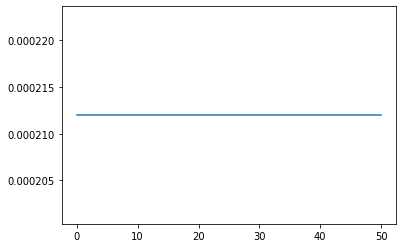

In [29]:
plt.figure()
plt.plot(t,xT)
plt.show()

In [30]:
t_span = np.array([0,50])
times = np.linspace(t_span[0], t_span[1], 101)

In [31]:
def mass_energy_bal2(t,y):
    # Define concentrations and Temps according to the output y
    c = y[::6]    # Benzene concentration
    h = y[1::6]
    s = y[2::6]   # sulfur concentration
    a = y[3::6]   # catalyst activity
    p = y[4::6]
    T = y[5::6]   # Temperature
    
    dx = 0.025
    P = 1.01e5 
    
    pram = lambda x: x
    prms = pram(prams)
    
    rho_B  = prms['rho_B']
    eps    = prms['eps']
    rho_Cp = prms['rho_Cp']
    dH     = prms['dH']
    Le     = prms['Le']
    U      = 0.05 # m/s
    P      = 1.03e5 # Pa
    #T      = 343.15 # K
    k0     = prms['k0']
    K0     = prms['K0']
    E      = prms['E']
    Q      = prms['Q']
    kd0    = prms['kd0']
    R      = prms['R']
    MT     = prms['MT']
    D      = prms['DeB']
    Ed     = prms['Ed']
   
    # initialize the output derivatives
    dydt = np.empty_like(y)

    # from the interleaved output derivatives slice out dcdt and dTdt
    # vectors in dydt.
    dcdt = dydt[::6]
    dhdt = dydt[1::6]
    dsdt = dydt[2::6]
    dadt = dydt[3::6]
    dpdt = dydt[4::6]
    dTdt = dydt[5::6]

    # Compute dc/dt and dT/dt considering the boundaries (end points) and the interior points
    dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + U*0 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                     rB(P,c[0],h[0],a[0],T[0],prams)
    
    dcdt[1:-1] = D * (c[:-2]-2.0*c[1:-1] + c[2:]) / dx**2 + U *(c[2:] - c[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* \
                     rB(P,c[1:-1],h[1:-1],a[1:-1],T[1:-1],prams)
        
    dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U *(c[-1]-c[-2])/dx + \
                     (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))*rB(P,c[-1],h[-1],a[-1],T[-1],prams)
    

    dhdt[0]    = D * (-2.0*h[0] + 2.0*h[1]) / dx**2 + U*0 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                      rB(P,c[0],h[0],a[0],T[0],prams)
    
    dhdt[1:-1] = D * (h[:-2]-2.0*h[1:-1] + h[2:]) / dx**2 + U *(h[2:] - h[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* \
                      rB(P,c[1:-1],h[1:-1],a[1:-1],T[1:-1],prams)    
    
    dhdt[-1]   = D * (- 2.0*h[-1] + 2.0*h[-2]) / dx**2 + U *(h[-1]-h[-2])/dx + \
                 (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))*rB(P,c[-1],h[-1],a[-1],T[-1],prams)
    
    
                  
    dsdt[0]    = D * (-2.0*s[0] + 2.0*s[1]) / dx**2 + U*0 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                  rT(P,s[0],a[0],T[0],prams) 
                  
    dsdt[1:-1] = D * (s[:-2]-2.0*c[1:-1] + s[2:]) / dx**2 + U *(s[2:] - s[:-2])/(2*dx) + \
                 (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* rT(P,s[1:-1],a[1:-1],T[1:-1],prams)
        
    dsdt[-1]   = D * (- 2.0*s[-1] + 2.0*s[-2]) / dx**2 + U *(s[-1]-s[-2])/dx +\
                 (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))* rT(P,s[-1],a[-1],T[-1],prams)
    
    
    dadt[0]    = rT(P,s[0],a[0],T[0],prams) 
    dadt[1:-1] = rT(P,s[1:-1],a[1:-1],T[1:-1],prams) 
    dadt[-1]   = rT(P,s[-1],a[-1],T[-1],prams)
    
    
    dpdt[0]    = D * (-2.0*p[0] + 2.0*p[1]) / dx**2 + U*0 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                     -rB(P,c[0],h[0],a[0],T[0],prams)
    
    dpdt[1:-1] = D * (p[:-2]-2.0*p[1:-1] + p[2:]) / dx**2 + U *(p[2:] - p[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* \
                     -rB(P,c[1:-1],h[1:-1],a[1:-1],T[1:-1],prams)
        
    dpdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U *(c[-1]-c[-2])/dx + \
                     (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))* -rB(P,c[-1],h[-1],a[-1],T[-1],prams)
    
   
    dTdt[0]    = Le/rho_Cp * (-2.0*T[0] + 2.0*T[1]) / dx**2 + (U*cp_g(c[0],h[0])*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))/(rho_Cp*mw_g(c[0],h[0]))*0 + \
                  (eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))/(rho_Cp*mw_g(c[0],h[0]))* H(dH,rB(P,c[0],h[0],a[0],T[0],prams)) 
                  
    dTdt[1:-1] = Le/rho_Cp * (T[:-2]-2.0*T[1:-1] + T[2:]) / dx**2 + U*cp_g(c[1:-1],h[1:-1])*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1])/(rho_Cp*mw_g(c[1:-1],h[1:-1]))*(T[2:] - T[:-2])/(2*dx) + \
                  (eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))/(rho_Cp*mw_g(c[1:-1],h[1:-1]))* H(dH,rB(P,c[1:-1],h[1:-1],a[1:-1],T[1:-1],prams))
                  
    dTdt[-1]   = Le/rho_Cp * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + (U * cp_g(c[-1],h[-1])* rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1])/(rho_Cp*mw_g(c[-1],h[-1]))) * (T[-1]-T[-2])/dx + \
                 (eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))/(rho_Cp*mw_g(c[-1],h[-1]))* H(dH,rB(P,c[-1],h[-1],a[-1],T[-1],prams))
    
    return dydt


In [32]:
solc = solve_ivp(mass_energy_bal2,t_span,y0, method='RK45', t_eval= times, dense_output=True,vectorized=True)

In [33]:
# solc

In [34]:
solc.y[0].shape

(101,)

In [35]:
x_solc1 = solc.sol(t).T

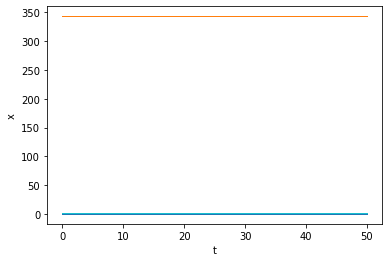

In [36]:
plt.figure()
plt.plot(t, x_solc1, linewidth=1)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

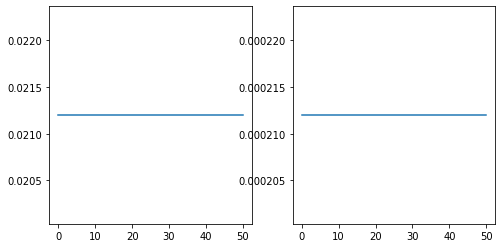

In [37]:
fig, axs = plt.subplots(1,2,figsize = (8,4))
axs[0].plot(solc.t, solc.y[0])
axs[1].plot(solc.t, solc.y[2])
plt.show()

In [38]:
# Example 
#v(n) = u(n+1)-u(n-1)/2*dt
#u'(0), v(0) = 0
#n(n) = u(n)-u(n-1)/dt
T = 100
dt = 0.025
Nt = int(round(T/dt))
u = np.zeros(Nt+1)
t = np.linspace(0, Nt*dt, Nt+1)

In [39]:
v = np.zeros_like(u) # or v = np.zeros(len(u))
# Use central difference for internal points
for i in range(1, len(u)-1):
    v[i] = (u[i+1] - u[i-1])/(2*dt)
# Use initial condition for u’(0) when i=0
v[0] = 0.1
# Use backward difference at the final mesh point
v[-1] = (u[-1] - u[-2])/dt

In [40]:
v = np.zeros_like(u)
v[1:-1] = (u[2:] - u[:-2])/(2*dt) # central difference
v[0] = 0 # boundary condition u’(0)
v[-1] = (u[-1] - u[-2])/dt # backward difference

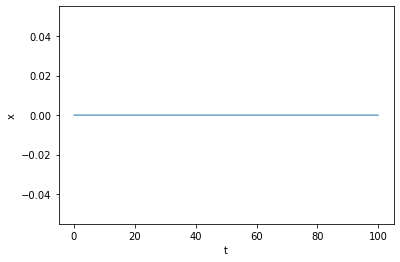

In [41]:
plt.figure()
plt.plot(t, v, linewidth=1)
plt.xlabel('t')
plt.ylabel('x')
plt.show()